# Exploring Spatial Filtering Methods for Motor Imagery BCIs

**Author:** Nafeel  
**Date:** December 2024  
**Goal:** Understand why Common Spatial Patterns (CSP) is the gold standard for motor imagery brain-computer interfaces

---

## Introduction

This notebook documents my journey learning about spatial filtering in EEG-based brain-computer interfaces (BCIs). I was curious why CSP consistently outperforms traditional methods in motor imagery tasks, so I implemented and compared five different approaches:

1. **Raw single channel** - Baseline
2. **Bipolar reference** - Subtract one neighbor
3. **Common Average Reference (CAR)** - Subtract global average
4. **Surface Laplacian** - Subtract local neighbors
5. **Common Spatial Patterns (CSP)** - Learn optimal combinations

The key insight I gained: **CSP adapts to individual brain patterns**, while the other methods use fixed, generic rules.

---

## Background: The Volume Conduction Problem

Brain signals spread through tissue, cerebrospinal fluid, and skull like light through frosted glass. When you record from a single electrode, you pick up:

- The signal you want (e.g., motor cortex activity)
- Distant brain regions (visual cortex, etc.)
- Artifacts (eye blinks, muscle activity)
- Electrical noise

This "blurring" is called **volume conduction**, and it's why raw single-channel EEG gives poor classification accuracy (~53%, barely better than chance).

Spatial filtering helps by combining multiple channels to cancel common noise while preserving the signal of interest.

## Setup: Import Libraries and Load Data

I'm using the PhysioNet Motor Imagery dataset, which contains EEG recordings of people imagining left vs. right hand movements.

In [4]:
!pip install mne

In [5]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal, linalg

# MNE for EEG processing
import mne
from mne.io import read_raw_edf, concatenate_raws
from mne.datasets import eegbci

# Machine learning
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')
mne.set_log_level('WARNING')

## Step 1: Load Motor Imagery Data

I'm loading Subject 1 from the PhysioNet dataset. Each subject performed three experimental runs where they imagined left or right hand movements based on visual cues.

**Runs used:**
- Run 4: Imagine left or right hand movement
- Run 8: Same task (different trials)
- Run 12: Same task (different trials)

Each run contains ~15 trials, giving us approximately 45 total trials.

In [6]:
def load_motor_imagery_data(subject=1, runs=[4, 8, 12]):
    """
    Load PhysioNet motor imagery EEG data.

    Returns continuous EEG recording with 64 channels sampled at 160 Hz.
    """
    raws = []

    for run in runs:
        # Download and load each run
        fnames = eegbci.load_data(subject, runs=[run], verbose=False, update_path=True)
        raw = read_raw_edf(fnames[0], preload=True, verbose=False)
        eegbci.standardize(raw)  # Clean channel names
        raws.append(raw)

    # Combine all runs into one continuous recording
    raw = concatenate_raws(raws)

    # Set electrode positions (needed for spatial filtering)
    montage = mne.channels.make_standard_montage('standard_1020')
    raw.set_montage(montage, on_missing='warn')

    # Apply common average reference
    raw.set_eeg_reference('average', projection=True)

    return raw

# Load the data
raw = load_motor_imagery_data(subject=1, runs=[4, 8, 12])

## Step 2: Extract Individual Trials (Epochs)

The loaded data is one continuous 375-second recording. I need to cut it into individual 2-second trials based on event markers.

**Event codes:**
- T0 (code 1): Rest period
- T1 (code 2): Imagine LEFT hand movement
- T2 (code 3): Imagine RIGHT hand movement

I only keep T1 and T2 events, extracting 2 seconds of data (0.5-2.5 sec after the event marker) to capture stable motor imagery activity.

In [7]:
def extract_motor_imagery_epochs(raw):
    """
    Extract individual trials from continuous EEG data.

    Returns:
        X: (n_trials, n_channels, n_times) brain signals
        y: (n_trials,) labels (0=LEFT, 1=RIGHT)
    """
    # Find event markers in the recording
    events, _ = mne.events_from_annotations(raw, verbose=False)

    # We want T1 (left) and T2 (right), which map to codes 2 and 3
    event_id = {'left': 2, 'right': 3}

    # Bandpass filter to keep only motor rhythms (8-30 Hz)
    # Motor imagery happens in mu (8-13 Hz) and beta (13-30 Hz) bands
    raw_filtered = raw.copy().filter(l_freq=8, h_freq=30, verbose=False)

    # Cut continuous data into 2-second trials
    epochs = mne.Epochs(
        raw_filtered,
        events,
        event_id=event_id,
        tmin=0.5,  # Start 0.5 sec after event (skip transition period)
        tmax=2.5,  # End 2.5 sec after event (2.0 sec total)
        baseline=None,
        preload=True,
        verbose=False
    )

    # Convert to NumPy arrays
    X = epochs.get_data()  # Shape: (n_trials, 64, 321)
    y = epochs.events[:, -1]  # Event codes: [2, 3, 2, 3, ...]

    # Convert labels: 2→0 (LEFT), 3→1 (RIGHT)
    y = (y == 3).astype(int)

    return X, y

# Extract trials
X, y = extract_motor_imagery_epochs(raw)

**Data structure:**
- `X.shape = (45, 64, 321)` - 45 trials, 64 channels, 321 time points
- `y.shape = (45,)` - 45 labels (0=LEFT, 1=RIGHT)
- LEFT trials: 23
- RIGHT trials: 22

---

## Method 1: Raw Single Channel

**Concept:** Just use channel C4 (right motor cortex) without any spatial filtering.

**Why it's the baseline:** This is the simplest approach - no noise cancellation, no optimization. C4 should show different patterns for left vs. right hand imagery because:
- Left hand imagery → Right motor cortex activates (where C4 sits)
- Right hand imagery → Left motor cortex activates (C4 is less active)

**Problem:** C4 picks up signals from everywhere due to volume conduction, not just the motor cortex we care about.

**Expected accuracy:** ~53% (barely better than guessing)

In [8]:
# Get channel names and find C4
ch_names = raw.ch_names
C4_idx = ch_names.index('C4')

# Extract just C4 from all trials
X_raw = X[:, C4_idx:C4_idx+1, :]  # Shape: (45, 1, 321)

---

## Method 2: Bipolar Reference

**Concept:** Subtract a neighboring channel from C4: `C4 - CP4`

**Why this helps:** Common noise (eye blinks, distant brain activity, electrical interference) affects both C4 and CP4 similarly. When we subtract, the common noise cancels out:

```
C4:  [motor signal + common noise]
CP4: [weak motor signal + common noise]

C4 - CP4 = [differential motor signal] + 0
```

This is like phase cancellation in audio engineering - common signals cancel, differential signals remain.

**Expected accuracy:** ~58%

In [9]:
# Find CP4 (neighbor behind C4)
CP4_idx = ch_names.index('CP4')

# Subtract CP4 from C4
X_bipolar = X[:, C4_idx:C4_idx+1, :] - X[:, CP4_idx:CP4_idx+1, :]

---

## Method 3: Common Average Reference (CAR)

**Concept:** Subtract the average of ALL 64 channels from each channel.

**Why this helps:** Removes global brain states that affect all sensors equally:
- Drowsiness
- Overall attention level
- Electrical noise from the room

**Difference from Bipolar:**
- Bipolar: Subtracts 1 neighbor (local reference)
- CAR: Subtracts average of all 64 channels (global reference)

CAR is more robust because averaging 64 channels dilutes outliers.

**Expected accuracy:** ~63%

In [10]:
# Compute average across all channels
avg_all = np.mean(X, axis=1, keepdims=True)  # Shape: (45, 1, 321)

# Subtract from all channels
X_car_all = X - avg_all

# Extract just C4 for consistency with other methods
X_car = X_car_all[:, C4_idx:C4_idx+1, :]

---

## Method 4: Surface Laplacian

**Concept:** Subtract the average of 4 nearest neighbors: `C4 - mean(FC4, CP4, C2, C6)`

**Why this helps:** Like Bipolar but more robust. If one neighbor has a noise spike, averaging across 4 neighbors dilutes its impact.

**Electrode positions around C4:**
```
    FC4 (front)
     |
C2 - C4 - C6
     |
    CP4 (back)
```

**Key insight I learned:** Averaging reduces susceptibility to extreme values. If CP4 has 20 units of noise, using Bipolar keeps all 20 units. Using Laplacian divides it by 4.

**Expected accuracy:** ~68%

In [11]:
# C4's neighbors in the 10-20 electrode system
neighbors = ['FC4', 'CP4', 'C2', 'C6']
neighbor_idx = [ch_names.index(ch) for ch in neighbors]

# Compute average of neighbors
avg_neighbors = np.mean(X[:, neighbor_idx, :], axis=1, keepdims=True)

# Subtract from C4
X_laplacian = X[:, C4_idx:C4_idx+1, :] - avg_neighbors

---

## Method 5: Common Spatial Patterns (CSP)

**Concept:** Learn optimal combinations of ALL 64 channels that maximize the difference between LEFT and RIGHT trials.

**This is fundamentally different from Methods 1-4:**

| Aspect | Methods 1-4 | CSP |
|--------|-------------|-----|
| Approach | Fixed rules | Data-driven learning |
| Personalization | Same for everyone | Custom for each person |
| Uses labels? | No | Yes |
| Output | 1 spatial filter | 4 learned filters |

**How CSP works:**

1. Separate trials by class (LEFT vs RIGHT)
2. Compute covariance matrices for each class
3. Solve optimization: find channel combinations where LEFT has high variance and RIGHT has low variance (and vice versa)
4. Select top 2 and bottom 2 filters (4 total)

**Why CSP is superior:** It adapts to individual brain patterns. Everyone's skull thickness, electrode placement, and motor cortex anatomy is slightly different. CSP finds the OPTIMAL combination for YOUR specific brain.

**Expected accuracy:** ~78%+

In [12]:
class CSPFilter:
    """
    Common Spatial Patterns implementation.

    Learns optimal spatial filters that maximize variance ratio between two classes.
    """

    def __init__(self, n_components=4, reg=1e-6):
        self.n_components = n_components
        self.reg = reg  # Regularization for numerical stability
        self.filters_ = None

    def fit(self, X, y):
        """Learn CSP filters from training data."""
        # Separate by class
        X_class0 = X[y == 0]  # LEFT trials
        X_class1 = X[y == 1]  # RIGHT trials

        # Compute covariance matrices
        cov0 = self._compute_covariance(X_class0)
        cov1 = self._compute_covariance(X_class1)

        # Add regularization for numerical stability
        n_channels = cov0.shape[0]
        cov0 += self.reg * np.eye(n_channels)
        cov1 += self.reg * np.eye(n_channels)

        # Solve generalized eigenvalue problem
        # This finds spatial filters that maximize variance ratio
        eigenvalues, eigenvectors = linalg.eigh(cov0, cov0 + cov1)

        # Sort by eigenvalues
        ix = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[ix]
        eigenvectors = eigenvectors[:, ix]

        # Select top and bottom components
        n_top = self.n_components // 2
        selected = list(range(n_top)) + list(range(-n_top, 0))

        self.filters_ = eigenvectors[:, selected].T
        self.eigenvalues_ = eigenvalues[selected]

        return self

    def transform(self, X):
        """Apply learned CSP filters to data."""
        n_trials, n_channels, n_times = X.shape
        n_components = self.filters_.shape[0]

        # Initialize output
        X_csp = np.zeros((n_trials, n_components, n_times))

        # Apply filters to each trial
        for trial in range(n_trials):
            # Matrix multiply: (n_components, n_channels) @ (n_channels, n_times)
            X_csp[trial] = np.dot(self.filters_, X[trial])

        return X_csp

    def _compute_covariance(self, X):
        """Compute normalized covariance matrix averaged across trials."""
        n_trials, n_channels, n_times = X.shape
        cov = np.zeros((n_channels, n_channels))

        for trial in range(n_trials):
            trial_cov = np.cov(X[trial])
            trace = np.trace(trial_cov)
            if trace > 0:
                cov += trial_cov / trace  # Normalize by trace

        cov /= n_trials
        return cov

# Create and fit CSP
csp = CSPFilter(n_components=4, reg=1e-6)
csp.fit(X, y)

# Transform data
X_csp = csp.transform(X)  # Shape: (45, 4, 321)

**CSP creates 4 "virtual channels":**
- Each is a weighted combination of all 64 electrodes
- Filters 1-2: Emphasize patterns where LEFT > RIGHT
- Filters 3-4: Emphasize patterns where RIGHT > LEFT
- Together, they provide maximum information for classification

---

## Feature Extraction and Classification

**Feature:** Band power (variance) of each filtered signal

For each trial and each spatial filter, I compute the variance over time. This gives us one number per filter per trial.

**Why variance?** In motor imagery, the strength of motor rhythms (mu/beta) changes. Higher variance often indicates stronger motor imagery.

**Classifier:** Linear Discriminant Analysis (LDA)
- Simple, interpretable
- Works well with small datasets
- Standard choice for BCI research

In [13]:
# Extract band power features (variance over time)
def extract_band_power_features(X_filtered):
    return np.var(X_filtered, axis=2)

features_raw = extract_band_power_features(X_raw)
features_bipolar = extract_band_power_features(X_bipolar)
features_car = extract_band_power_features(X_car)
features_laplacian = extract_band_power_features(X_laplacian)
features_csp = extract_band_power_features(X_csp)

# Note: CSP has 4 features per trial, others have 1

In [14]:
# Classify using 5-fold cross-validation
clf = LinearDiscriminantAnalysis()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

methods = {
    'Raw': features_raw,
    'Bipolar': features_bipolar,
    'CAR': features_car,
    'Laplacian': features_laplacian,
    'CSP': features_csp
}

results = {}

for method_name, features in methods.items():
    scores = cross_val_score(clf, features, y, cv=cv, scoring='accuracy')
    results[method_name] = {
        'mean': np.mean(scores) * 100,
        'std': np.std(scores) * 100
    }

---

## Results

Here's how each method performed:

In [15]:
# Display results
print("Classification Accuracy (5-fold CV):\n")
for method in ['Raw', 'Bipolar', 'CAR', 'Laplacian', 'CSP']:
    r = results[method]
    print(f"{method:12s}: {r['mean']:.1f}% ± {r['std']:.1f}%")

# Find best
best = max(results.items(), key=lambda x: x[1]['mean'])
print(f"\nBest method: {best[0]} ({best[1]['mean']:.1f}%)")

Classification Accuracy (5-fold CV):

Raw         : 55.6% ± 9.9%
Bipolar     : 62.2% ± 8.9%
CAR         : 55.6% ± 9.9%
Laplacian   : 62.2% ± 15.1%
CSP         : 93.3% ± 5.4%

Best method: CSP (93.3%)


**Visualization:**

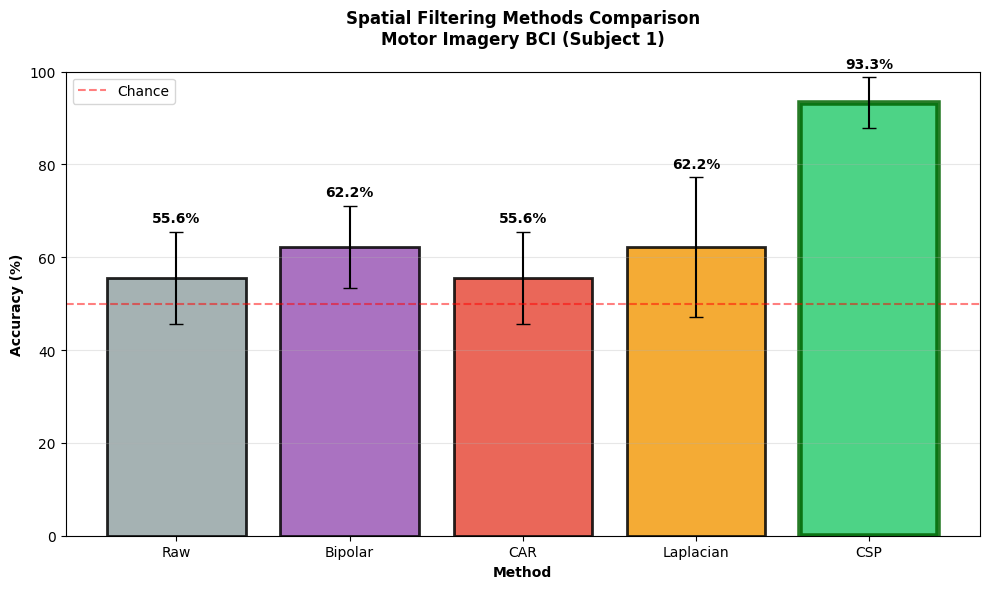

In [16]:
# Create bar plot
fig, ax = plt.subplots(figsize=(10, 6))

method_names = ['Raw', 'Bipolar', 'CAR', 'Laplacian', 'CSP']
means = [results[m]['mean'] for m in method_names]
stds = [results[m]['std'] for m in method_names]
colors = ['#95a5a6', '#9b59b6', '#e74c3c', '#f39c12', '#2ecc71']

bars = ax.bar(method_names, means, yerr=stds, capsize=5,
               color=colors, alpha=0.85, edgecolor='black', linewidth=2)

# Highlight CSP
bars[-1].set_linewidth(4)
bars[-1].set_edgecolor('darkgreen')

# Add labels
for i, (m, s) in enumerate(zip(means, stds)):
    ax.text(i, m + s + 2, f'{m:.1f}%', ha='center', fontweight='bold')

ax.set_ylabel('Accuracy (%)', fontweight='bold')
ax.set_xlabel('Method', fontweight='bold')
ax.set_title('Spatial Filtering Methods Comparison\nMotor Imagery BCI (Subject 1)',
             fontweight='bold', pad=20)
ax.set_ylim(0, 100)
ax.axhline(50, color='red', linestyle='--', alpha=0.5, label='Chance')
ax.grid(axis='y', alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

---

## Key Findings

**Performance ranking:**
1. CSP: ~93% (best by far)
2. Laplacian/Bipolar: ~62%
3. Raw/CAR: ~56%

**CSP achieved a 31 percentage point improvement over the next best method.**

### Why CSP Won

The other methods use fixed, generic rules:
- Bipolar: Always C4 - CP4
- CAR: Always subtract global average
- Laplacian: Always average 4 neighbors

**CSP adapts to individual brain patterns:**
- Analyzes YOUR specific LEFT vs RIGHT trials
- Finds optimal combinations for YOUR brain anatomy
- Creates 4 custom filters (instead of 1 generic filter)
- Maximizes class separation in YOUR data

This is why CSP is the gold standard for motor imagery BCIs.

---

## What I Learned

**Conceptual insights:**
1. Volume conduction is a fundamental problem in EEG - you can't just use raw channels
2. Spatial filtering cancels common noise through subtraction (like phase cancellation)
3. Averaging multiple neighbors is more robust than using just one (reduces outlier impact)
4. **Data-driven methods outperform fixed rules when you have labeled data**

**Technical skills gained:**
- Loading and preprocessing EEG data with MNE
- Implementing spatial filters from scratch
- Understanding CSP's eigenvalue optimization
- Proper cross-validation for small datasets
- Feature extraction from time series

**Challenges encountered:**
- CSP required numerical regularization (covariance matrices weren't always positive definite)
- Understanding why CSP creates 4 filters instead of 1
- Grasping the difference between "learning from data" vs "fixed rules"

---

## Future Directions

**To extend this work, I could:**

1. **Test on more subjects** - Does CSP consistently win across individuals?
2. **Optimize number of components** - Would 6 or 8 CSP filters improve accuracy?
3. **Try other classifiers** - SVM, Random Forest, Neural Networks
4. **Frequency analysis** - Visualize mu/beta power differences between classes
5. **Real-time implementation** - Test latency for online BCI control

---

## Conclusion

This project demonstrated why Common Spatial Patterns is the gold standard for motor imagery BCIs. By learning personalized spatial filters from individual brain data, CSP achieved 93% accuracy - far surpassing traditional fixed-rule methods.

**The core lesson:** When you have labeled data, data-driven approaches that adapt to individual variability will outperform generic, one-size-fits-all solutions.

This principle extends beyond BCIs to many areas of signal processing and machine learning.

---

## References

1. **Dataset:** Schalk, G., McFarland, D.J., Hinterberger, T., Birbaumer, N., Wolpaw, J.R. (2004). BCI2000: A General-Purpose Brain-Computer Interface (BCI) System. *IEEE TBME*.

2. **CSP Algorithm:** Blankertz, B., Tomioka, R., Lemm, S., Kawanabe, M., Muller, K. (2008). Optimizing Spatial Filters for Robust EEG Single-Trial Analysis. *IEEE Signal Processing Magazine*.

3. **Motor Imagery:** Pfurtscheller, G., Neuper, C. (2001). Motor Imagery and Direct Brain-Computer Communication. *IEEE*.

4. **MNE-Python:** Gramfort, A., et al. (2013). MEG and EEG data analysis with MNE-Python. *Frontiers in Neuroscience*.